In [1]:
import scanpy as sc
import numpy as np

# -----------------------------
# Step 1: Load normalized AnnData
# -----------------------------
adata_pbmc = sc.read_h5ad("../data/processed/pbmc/pbmc_10k_normalized.h5ad")
adata_brca = sc.read_h5ad("../data/processed/tcga/normalized/TCGA-BRCA_normalized.h5ad")
adata_luad = sc.read_h5ad("../data/processed/tcga/normalized/TCGA-LUAD_normalized.h5ad")
adata_lusc = sc.read_h5ad("../data/processed/tcga/normalized/TCGA-LUSC_normalized.h5ad")

# -----------------------------
# Step 2: Fix PBMC var_names to match Ensembl format
# -----------------------------
adata_pbmc.var_names = adata_pbmc.var["gene_ids"]
adata_pbmc.var_names_make_unique()

# -----------------------------
# Step 3: (Optional) Ensure float32 format for matrix
# -----------------------------
for ad in [adata_pbmc, adata_brca, adata_luad, adata_lusc]:
    ad.X = ad.X.astype(np.float32)

# -----------------------------
# Step 4: Find intersecting genes across all datasets
# -----------------------------
common_genes = set(adata_pbmc.var_names)
for ad in [adata_brca, adata_luad, adata_lusc]:
    common_genes &= set(ad.var_names)

common_genes = sorted(list(common_genes))
print(f"Number of common genes: {len(common_genes)}")

# -----------------------------
# Step 5: Subset all to common genes
# -----------------------------
adata_pbmc = adata_pbmc[:, common_genes].copy()
adata_brca = adata_brca[:, common_genes].copy()
adata_luad = adata_luad[:, common_genes].copy()
adata_lusc = adata_lusc[:, common_genes].copy()

# -----------------------------
# Step 6: Add source labels
# -----------------------------
adata_pbmc.obs["source"] = "pbmc"
adata_brca.obs["source"] = "brca"
adata_luad.obs["source"] = "luad"
adata_lusc.obs["source"] = "lusc"

# -----------------------------
# Step 7: Merge datasets (scanpy >=1.9: use `anndata.concat`)
# -----------------------------
import anndata as ad

adata_merged = ad.concat(
    [adata_pbmc, adata_brca, adata_luad, adata_lusc],
    label="source",
    keys=["pbmc", "brca", "luad", "lusc"],
    index_unique=None,
    join="inner"
)

print("Merged shape:", adata_merged.shape)
print(adata_merged.obs["source"].value_counts())

Number of common genes: 36516


/home/ubuntu/.local/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Merged shape: (2100720, 36516)
source
pbmc    2099284
brca        644
luad        418
lusc        374
Name: count, dtype: int64


In [11]:
# adata_merged.write("../data/processed/common/merged_pbmc_tcga.h5ad")

In [3]:
# -----------------------------
# Step 6: Batch-aware HVG selection (recording-based strategy)
# -----------------------------

# sc.pp.highly_variable_genes(
#     adata_merged,
#     flavor="seurat_v3",
#     batch_key="source",
#     n_top_genes=2000,
#     subset=False,
#     inplace=True
# )

# # Add per-gene HVG summary
# nbatches = adata_merged.obs["source"].nunique()
# threshold = int(threshold_ratio * nbatches) # added
# adata_merged.var["n_batches_hvg"] = adata_merged.var["highly_variable_nbatches"]
# #added
# mask = adata.var["n_batches_hvg"] >= threshold
# adata = adata[:, mask].copy()

# # Dimensionality reduction
# sc.pp.scale(adata, max_value=10, zero_center=False)
# sc.tl.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

# return adata


def run_hvg_and_umap(adata_input, threshold_ratio):
    adata = adata_input.copy()
    
    # HVG Selection (batch-aware)
    sc.pp.highly_variable_genes(
        adata,
        flavor="seurat_v3",
        batch_key="source",
        n_top_genes=2000,
        subset=False,
        inplace=True
    )
    
    # Batch HVG filtering
    nbatches = adata.obs["source"].nunique()
    threshold = int(threshold_ratio * nbatches)
    adata.var["n_batches_hvg"] = adata.var["highly_variable_nbatches"]
    mask = adata.var["n_batches_hvg"] >= threshold
    adata = adata[:, mask].copy()
    
    # Dimensionality reduction
    sc.pp.scale(adata, max_value=10, zero_center=False)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    
    return adata

# -----------------------------
# 3. Evaluation metric functions
# -----------------------------
def compute_metrics(adata, label_key="source"):
    X = adata.obsm["X_pca"]
    labels = adata.obs[label_key]
    
    sil = silhouette_score(X, labels)
    
    # Entropy per neighborhood
    neighbors = adata.obsp["connectivities"]
    entropy_vals = []
    for i in range(neighbors.shape[0]):
        neighbor_ids = neighbors[i].nonzero()[1]
        neighbor_labels = labels.iloc[neighbor_ids]
        counts = neighbor_labels.value_counts()
        p = counts / counts.sum()
        entropy_vals.append(entropy(p, base=2))
    avg_entropy = np.mean(entropy_vals)
    
    return sil, avg_entropy


In [ ]:
ratios = [0.25, 0.5, 0.75]
results = []

for ratio in ratios:
    ad_norm = run_hvg_and_umap(adata_merged, threshold_ratio=ratio)
    ad_down = run_hvg_and_umap(adata_down, threshold_ratio=ratio)
    
    sil_norm, ent_norm = compute_metrics(ad_norm)
    sil_down, ent_down = compute_metrics(ad_down)
    
    results.append({
        "Threshold": f"≥{int(ratio*adata_merged.obs['source'].nunique())}",
        "Dataset": "Full",
        "Silhouette": sil_norm,
        "Entropy": ent_norm
    })
    results.append({
        "Threshold": f"≥{int(ratio*adata_merged.obs['source'].nunique())}",
        "Dataset": "Downsampled",
        "Silhouette": sil_down,
        "Entropy": ent_down
    })

df_results = pd.DataFrame(results)
print(df_results)

/home/ubuntu/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


Threshold ≥1/4 batches → 5447 genes


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Threshold ≥2/4 batches → 1725 genes


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/ubuntu/.local/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Threshold ≥3/4 batches → 748 genes


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


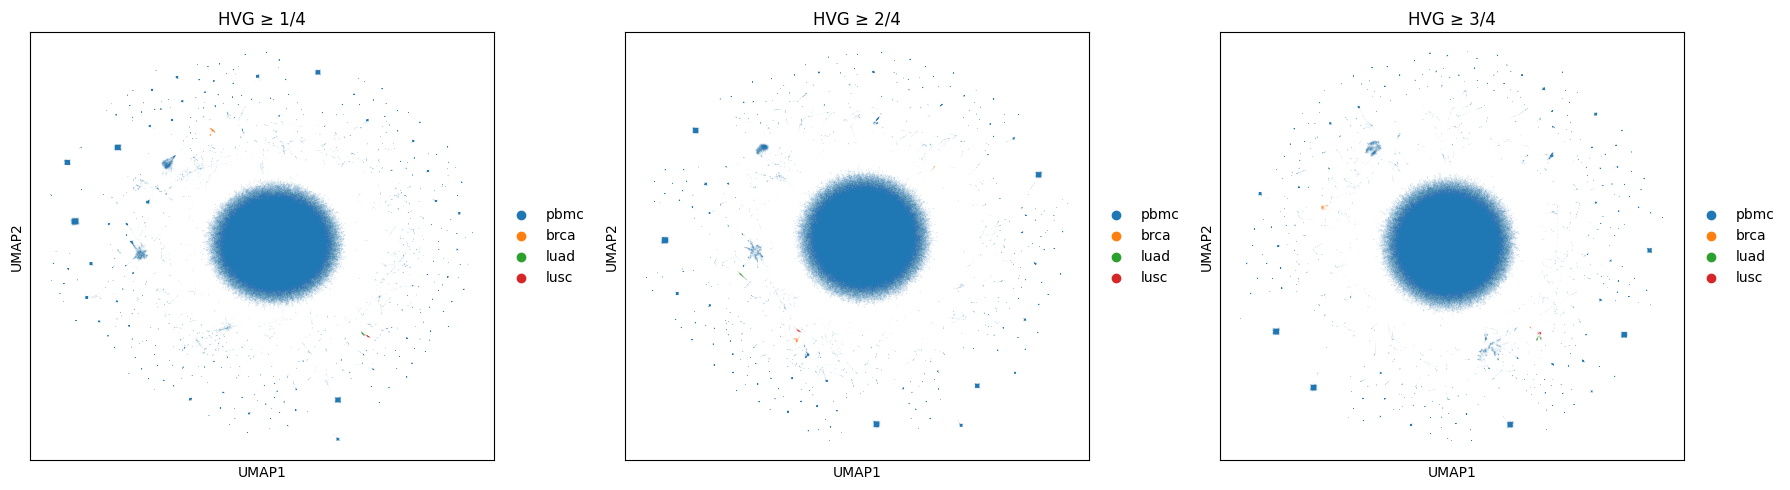

In [15]:
# -----------------------------
# Step 7: UMAP with different batch thresholds (recording strategy)
# -----------------------------

ratios = [0.25, 0.5, 0.75]
fig, axes = plt.subplots(1, len(ratios), figsize=(18, 5))

# Inside the loop
for ax, ratio in zip(axes, ratios):
    threshold = int(ratio * nbatches)
    mask = adata_merged.var["n_batches_hvg"] >= threshold
    ad_sub = adata_merged[:, mask].copy()

    print(f"Threshold ≥{threshold}/{nbatches} batches → {ad_sub.shape[1]} genes")

    sc.pp.scale(ad_sub, max_value=10, zero_center=False)  # <--- sparse safe
    sc.tl.pca(ad_sub)
    sc.pp.neighbors(ad_sub)
    sc.tl.umap(ad_sub)

    sc.pl.umap(ad_sub, color="source", show=False, ax=ax, title=f"HVG ≥ {threshold}/{nbatches}")


plt.tight_layout()
plt.show()

In [ ]:
# adata_merged.write("../data/processed/merged/pbmc_tcga_merged_with_hvg_info.h5ad")

In [6]:
# integrating the HVG selection strategy 
import anndata as ad
import scanpy as sc

# load data
adata_pbmc = sc.read_h5ad("../data/processed/common/PBMC_10k_filtered_common_genes.h5ad")
adata_brca = sc.read_h5ad("../data/processed/common/TCGA-BRCA_filtered_common_genes.h5ad")
adata_luad = sc.read_h5ad("../data/processed/common/TCGA-LUAD_filtered_common_genes.h5ad")
adata_lusc = sc.read_h5ad("../data/processed/common/TCGA-LUSC_filtered_common_genes.h5ad")

# datasets = {
#     "PBMC": sc.read_h5ad("../data/processed/common/PBMC_10k_filtered_common_genes.h5ad"),
#     "BRCA": sc.read_h5ad("../data/processed/common/TCGA-BRCA_filtered_common_genes.h5ad"),
#     "LUAD": sc.read_h5ad("../data/processed/common/TCGA-LUAD_filtered_common_genes.h5ad"),
#     "LUSC": sc.read_h5ad("../data/processed/common/TCGA-LUSC_filtered_common_genes.h5ad"),
# }

# Step 1: Align var_names with 'gene_id_clean'
for adata in [adata_pbmc, adata_brca, adata_luad, adata_lusc]:
    # Convert gene_id_clean to string (in case it's categorical or other type)
    adata.var_names = adata.var["gene_id_clean"].astype(str)
    adata.var_names_make_unique()

# Step 2: Get common genes
common_genes = set(adata_pbmc.var_names)
for adata in [adata_brca, adata_luad, adata_lusc]:
    common_genes &= set(adata.var_names)

print("✅ Common gene count:", len(common_genes))

# Step 3: Subset to common genes
adata_pbmc = adata_pbmc[:, adata_pbmc.var_names.isin(common_genes)].copy()
adata_brca = adata_brca[:, adata_brca.var_names.isin(common_genes)].copy()
adata_luad = adata_luad[:, adata_luad.var_names.isin(common_genes)].copy()
adata_lusc = adata_lusc[:, adata_lusc.var_names.isin(common_genes)].copy()

# Step 4: Merge
merged = ad.concat(
    {
        "PBMC": adata_pbmc,
        "BRCA": adata_brca,
        "LUAD": adata_luad,
        "LUSC": adata_lusc
    },
    label="batch",
    join="inner",
    index_unique="_"
)

# Optional: Save merged
merged.write("merged_pbmc_tcga_final.h5ad")

# Print confirmation
print(merged)


✅ Common gene count: 19618
AnnData object with n_obs × n_vars = 2100720 × 19618
    obs: 'batch'


In [7]:
adata_merged = ad.concat(
    {
        "PBMC": adata_pbmc,
        "BRCA": adata_brca,
        "LUAD": adata_luad,
        "LUSC": adata_lusc
    },
    label="batch",
    join="inner",
    index_unique="_"
)

In [8]:
adata_merged

AnnData object with n_obs × n_vars = 2100720 × 19618
    obs: 'batch'

In [9]:
import scanpy as sc
import numpy as np

# Step 0: Ensure float32
adata_merged.X = adata_merged.X.astype("float32")

# Step 1: Store raw counts before normalization
adata_merged.layers["counts"] = adata_merged.X.copy()

# Step 2: Normalize and log1p (RPM-like)
sc.pp.normalize_total(adata_merged, target_sum=1e6)
sc.pp.log1p(adata_merged)
adata_merged.raw = adata_merged.copy()

# Step 3: Batch-aware HVG selection
sc.pp.highly_variable_genes(
    adata_merged,
    flavor="seurat_v3",
    batch_key="batch",
    n_top_genes=2000,
    subset=False
)

# Step 4: Batch-count-based filtering
nbatches = adata_merged.obs["batch"].nunique()
adata_merged.var["n_batches_hvg"] = adata_merged.var["highly_variable_nbatches"]
threshold = int(0.5 * nbatches)
mask = adata_merged.var["n_batches_hvg"] >= threshold
adata_merged.var["highly_variable"] = mask

# Step 5: Subset to final HVGs
adata_merged = adata_merged[:, mask].copy()
print(f"Selected {mask.sum()} HVGs across ≥{threshold}/{nbatches} batches")

# Step 6: Finalize counts layer for modeling
adata_merged.X = adata_merged.layers["counts"]  # counts of selected HVGs
adata_merged.layers = {"counts": adata_merged.X}


/home/ubuntu/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/home/ubuntu/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


Selected 1995 HVGs across ≥2/4 batches


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    batch_key="batch",
    n_top_genes=2000,
    subset=False,
    inplace=True
)

sc.pl.highly_variable_genes(adata_merged)

# Check: 'highly_variable' and 'n_batches_hvg' must exist
assert "highly_variable" in adata_merged.var.columns
assert "n_batches_hvg" in adata_merged.var.columns

# Plot 1: Distribution of HVG presence across batches
adata_merged.var["n_batches_hvg"].value_counts().sort_index().plot.bar()
plt.title("HVG distribution across batches")
plt.xlabel("Number of batches")
plt.ylabel("Number of genes")
plt.tight_layout()
plt.show()

# Plot 2: HVG vs non-HVG expression features
sc.pl.highly_variable_genes(adata)


In [ ]:
for ratio in [0.25, 0.5, 0.75]:
    threshold = int(ratio * nbatches)
    mask = adata_merged.var["n_batches_hvg"] >= threshold
    print(f"Threshold: ≥{threshold}/{nbatches} batches → {mask.sum()} genes")

In [ ]:
import scanpy as sc
import numpy as np

# Load

adata_merged.X = adata_merged.X.astype("float32")  # ensure float

# Step 1: Store raw counts in separate layer
adata_merged.layers["counts"] = adata_merged.X.copy()

# Step 2: Normalize only (no log1p yet!)
sc.pp.normalize_total(adata_merged, target_sum=1e6)

# Step 3: HVG calculation BEFORE log1p
sc.pp.highly_variable_genes(
    adata_merged,
    flavor="seurat_v3",
    batch_key="batch",
    n_top_genes=2000,
    subset=False
)

# Step 4: Calculate batch thresholds
nbatches = adata_merged.obs["batch"].nunique()
adata.var["n_batches_hvg"] = adata_merged.var["highly_variable_nbatches"]

# Step 5: Log-transform after HVG
sc.pp.log1p(adata_merged)
adata_merged.raw = adata_merged.copy()

# Step 6: UMAP comparison with thresholds
ratios = [0.25, 0.5, 0.75]
import matplotlib.pyplot as plt
import scanpy as sc

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, ratio in zip(axes, ratios):
    threshold = int(ratio * nbatches)
    mask = adata_merged.var["n_batches_hvg"] >= threshold
    ad_sub = adata_merged[:, mask].copy()
    
    print(f"Threshold ≥{threshold}/{nbatches} batches → {ad_sub.shape[1]} genes")
    
    sc.pp.scale(ad_sub, max_value=10)
    sc.tl.pca(ad_sub)
    sc.pp.neighbors(ad_sub)
    sc.tl.umap(ad_sub)
    
    sc.pl.umap(ad_sub, color="batch", ax=ax, show=False,
               title=f"HVG ≥ {threshold}/{nbatches}")

plt.tight_layout()
plt.show()
